In [ ]:
# Extract Data into Dataframe

import pandas as pd 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

df = pd.read_csv("p2_dataset.csv",
    usecols = [
        "track_id", "popularity", "duration_ms", "explicit", "danceability", "energy", "key", "loudness", "mode", 
         "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature", "track_genre"
    ]
)
df["explicit"] = df["explicit"].astype(int)
df["popularity"] = df["popularity"].astype(int)

numeric_cols = [
    "popularity", "duration_ms", "explicit", "danceability", "energy", "key", "loudness", "mode",
    "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"
]
df[numeric_cols] = StandardScaler().fit_transform(df[numeric_cols])

In [ ]:
# Functions to Remove Variables with Low Variance, and High Correlations with Each Other

import numpy as np

def remove_low_variance(columns, threshold = 0.01):
    keep = []
    for col in columns:
        column = df[col]
        variance = np.var(column)
        if variance >= threshold:
            keep.append(col)
    return keep

def remove_high_correlation(columns, threshold = 0.8):
    keep = columns
    remove = []
    corr_baseline = np.corrcoef(df[columns].values, rowvar = False)
    for i, col_i in enumerate(columns):
        if col_i not in remove:
            for j, col_j in enumerate(columns[i+1:]):
                if col_j not  in remove:
                    if abs(corr_baseline[i, j]) > threshold:
                        remove.append(col_j)
    for col in remove:
        keep.remove(col)
    return keep

In [ ]:
keep_low_var = remove_low_variance(numeric_cols)
keep_high_corr = remove_high_correlation(numeric_cols)

keep_cols = []
for col in keep_low_var:
    if col in keep_high_corr:
        keep_cols.append(col)

print(keep_cols)


['popularity', 'explicit', 'danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness', 'liveness', 'valence', 'time_signature']


In [ ]:
# Test the Impact of Removing Remaining Variables on the Cluster and Remove Variables with Low Impact

from sklearn.metrics import adjusted_rand_score
import copy

cluster_baseline = KMeans(n_clusters = 8, random_state = 42).fit_predict(df[keep_cols])
correlation = {}
for i in range(len(keep_cols)):
    df_temp = df[keep_cols[:i] + keep_cols[i+1:]]
    cluster_temp = KMeans(n_clusters = 8, random_state = 42).fit_predict(df_temp)
    ari = adjusted_rand_score(cluster_baseline, cluster_temp)
    correlation[keep_cols[i]] = ari

for col, corr in correlation.items():
    if corr > 0.6:
        keep_cols.remove(col)

print(keep_cols)



['popularity', 'danceability', 'energy', 'loudness', 'instrumentalness', 'liveness', 'valence']


This algorithm compares the ARI after removing a column with the ARI with all columns included. 

Higher correlation indicates that removing the column will not significantly change the ARI, and vise versa for low correlation. 

A correlation of >0.6 indicates that the variable can be removed with low effect on cluster assignments. 

In [ ]:
# Determine the Optimal Number of Clusters

from sklearn.metrics import silhouette_score

coefficients = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters = k, random_state = 42)
    labels = kmeans.fit_predict(df[keep_cols])
    coefficient = silhouette_score(df[keep_cols], labels)
    coefficients.append((k, coefficient))
    print(f"{k} clusters with silhouette score {coefficient}")

2 clusters with silhouette score 0.2617481547512818
3 clusters with silhouette score 0.17215191032342733
4 clusters with silhouette score 0.1767061837831547
5 clusters with silhouette score 0.1939164505930234
6 clusters with silhouette score 0.19148298254118756
7 clusters with silhouette score 0.20465366075736666
8 clusters with silhouette score 0.19226885679790925
9 clusters with silhouette score 0.18955667525007205
10 clusters with silhouette score 0.17615471886062498
11 clusters with silhouette score 0.17484270533655424
12 clusters with silhouette score 0.17763343268141654
13 clusters with silhouette score 0.17329101361335747
14 clusters with silhouette score 0.1693357217747477
15 clusters with silhouette score 0.1661522128770961
16 clusters with silhouette score 0.16147402028107166
17 clusters with silhouette score 0.1651100997457826
18 clusters with silhouette score 0.16370821600445962
19 clusters with silhouette score 0.15969731214816923


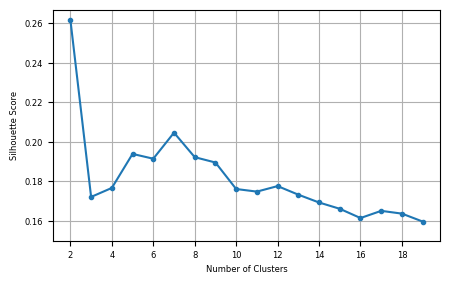

In [93]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

k_values = []
sil_values = []
for val in coefficients:
    k_values.append(val[0])
    sil_values.append(val[1])

plt.figure(figsize = (5, 3))
plt.plot(k_values, sil_values, marker = ".")
plt.xlabel("Number of Clusters", fontsize = 6)
plt.ylabel("Silhouette Score", fontsize = 6)

plt.gca().xaxis.set_major_locator(MaxNLocator(integer = True))
plt.ylim(bottom = 0.15)
plt.xticks(fontsize = 6)
plt.yticks(fontsize = 6)
plt.grid(True)
plt.show()



Number of Clusters = 7 is chosen
It balances a high silhouette score with enough clusters to distinguish between multiple genres. 

In [94]:
ideal_k = 7

C:\Users\lixin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


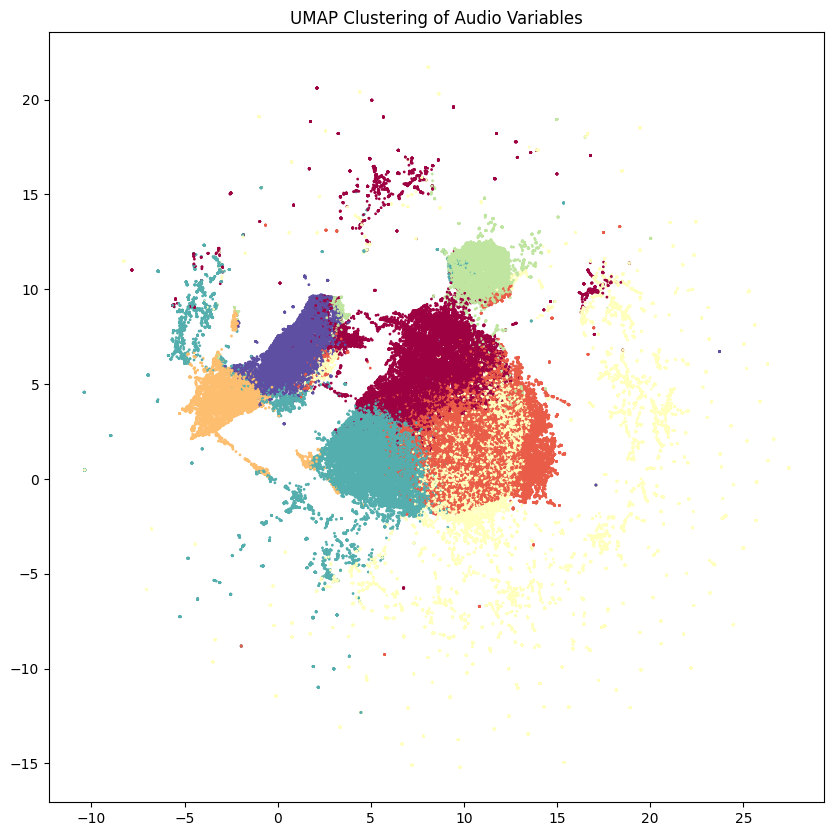

In [ ]:
# Reduce and Visualize Clusters in 2D Space Using UMAP

import umap
import matplotlib.pyplot as plt
X = df[keep_cols].values
cluster_labels = KMeans(n_clusters = ideal_k, random_state = 42).fit_predict(X)
cluster_array = umap.UMAP(n_components = 2, init = "pca", random_state = 42).fit_transform(X)

plt.figure(figsize = (10, 10))
plt.scatter(
    cluster_array[: ,0],
    cluster_array[: ,1],
    c = cluster_labels,
    cmap = "Spectral",
    s = 1
)


plt.title("UMAP Clustering of Audio Variables")
plt.show()

Purity is a cluster evaluation metric that determines how consistent each cluster is with respect to the true music genres. A higher purity indicates greater clustering accuracy. 

In [ ]:
# Purity and Dominant Cluster by Genre

df_compare = pd.DataFrame({
    "cluster": cluster_labels,
    "genre": df["track_genre"]
})

purity = (
    df_compare.groupby("genre")["cluster"]
    .agg(lambda x: x.value_counts().max() / len(x))
)

dominant_cluster = (
    df_compare.groupby("genre")["cluster"]
    .agg(lambda x: x.value_counts().idxmax())
)

results = pd.DataFrame({
    "purity": purity,
    "dominant": dominant_cluster
})

print(results)

             purity  dominant
genre                        
acoustic      0.562         5
afrobeat      0.458         3
alt-rock      0.291         1
alternative   0.390         3
ambient       0.630         2
...             ...       ...
techno        0.618         6
trance        0.464         6
trip-hop      0.381         6
turkish       0.465         1
world-music   0.343         5

[114 rows x 2 columns]


In [ ]:
# Categorize Genre Clustering by Very Weak, Weak, Moderate, Good, and Excellent
bins = pd.cut(
    results["purity"], bins = [0, 0.3, 0.45, 0.6, 0.75, 1], 
    labels = ["very weak", "weak", "moderate", "good", "excellent"]
)
bins.value_counts()

purity
weak         48
moderate     35
good         19
excellent     7
very weak     5
Name: count, dtype: int64

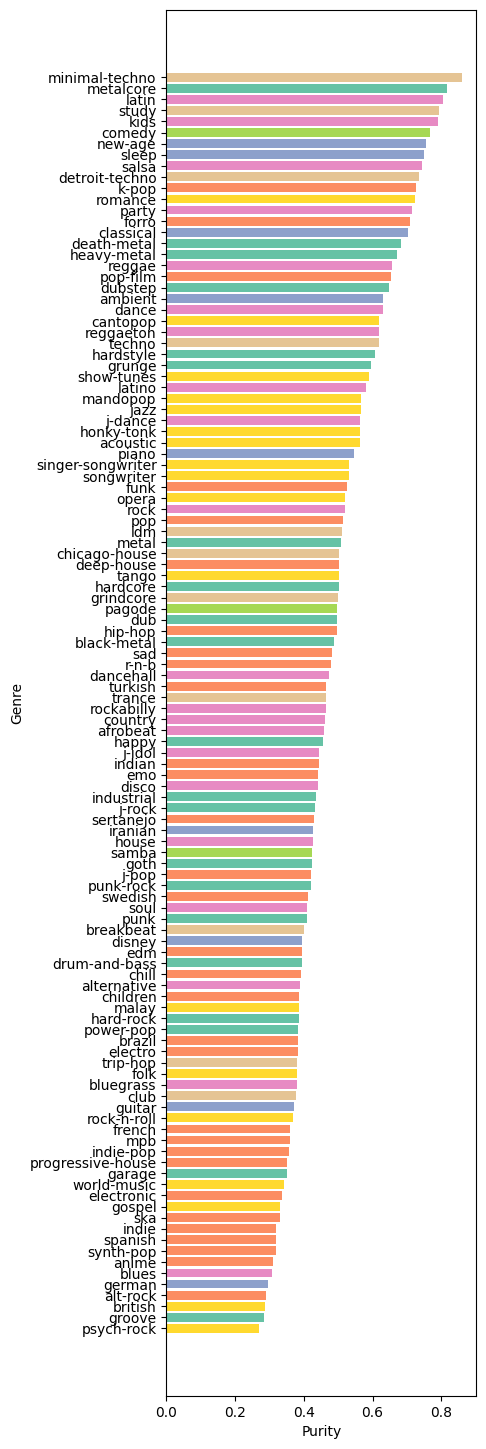

In [ ]:
# Genre and Purity (Colored by Cluster Grouping)

results_sorted = results.sort_values("purity", ascending = False)
colors = sns.color_palette("Set2", n_colors = results["dominant"].nunique())
cluster_colors = {}
for i, cluster in enumerate(sorted(results["dominant"].unique())):
    cluster_colors[cluster] = colors[i]
bar_colors = results_sorted["dominant"].map(cluster_colors)
plt.figure(figsize = (4, 18))
plt.barh(results_sorted.index, results_sorted["purity"], color = bar_colors)
plt.xlabel("Purity")
plt.ylabel("Genre")
plt.gca().invert_yaxis()
plt.show()